# Ejercicion de programación - Regresión Logistica

En este ejercicio se implementa regresion logistica y se aplica a dos diferentes datasets.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# se utiliza para el manejo de rutas y directorios.
import os

# Calculo cientifico y vectorial para python
import numpy as np

# Librerias para graficar
from matplotlib import pyplot

# Modulo de optimización de scipy
from scipy import optimize

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

## 1 Regresion Logistica

En esta parte del ejercicio, creará un modelo de regresión logística para predecir si un estudiante será admitido en una universidad. Suponga que es el administrador de un departamento universitario y desea determinar las posibilidades de admisión de cada solicitante en función de sus resultados en dos exámenes. Tiene datos históricos de solicitantes anteriores que puede usar como un conjunto de capacitación para la regresión logística. Para cada ejemplo de capacitación, se tiene las calificaciones del solicitante en dos exámenes y la decisión de admisión. Su tarea es crear un modelo de clasificación que calcule la probabilidad de admisión de un solicitante en función de los puntajes de esos dos exámenes.

La siguiente celda cargará los datos y las etiquetas correspondientes:

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# Cargar el archivo CSV
data = np.loadtxt('/content/drive/MyDrive/lab1/lab3/Challenger_Ranked_Games.csv', delimiter=',', skiprows=1)

# Asignar X y y. Aquí, X contendrá las primeras 10 columnas, y y será la última columna.
X, y = data[:, :-1], data[:, -1]

# Dividir los datos en conjunto de entrenamiento (80%) y de prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imprimir las dimensiones de los conjuntos de entrenamiento y prueba para verificar
print(f'Tamaño del conjunto de entrenamiento: {X_train.shape}, {y_train.shape}')
print(f'Tamaño del conjunto de prueba: {X_test.shape}, {y_test.shape}')

Tamaño del conjunto de entrenamiento: (21522, 10), (21522,)
Tamaño del conjunto de prueba: (5381, 10), (5381,)


### 1.1 Visualizar los datos

Antes de comenzar a implementar cualquier algoritmo de aprendizaje, siempre es bueno visualizar los datos si es posible. Mostramos los datos en una gráfica bidimensional llamando a la función `plotData`. Se completará el código en `plotData` para que muestre una figura donde los ejes son los dos puntajes de los dos examenes, los ejemplos positivos y negativos se muestran con diferentes marcadores.

In [5]:
def plotData(X, y):
    # Gragica los puntos de datos X y y en una nueva figura. Grafica los puntos de datos con * para los positivos y
    # o para los negativos.

    # Crea una nueva figura
    fig = pyplot.figure()

    # Find Indices of Positive and Negative Examples
    pos = y == 1
    neg = y == 0

    # Plot Examples
    pyplot.plot(X[pos, 0], X[pos, 1], 'k*', lw=2, ms=10)
    pyplot.plot(X[neg, 0], X[neg, 1], 'ko', mfc='y', ms=8, mec='k', mew=1)


Se llama a la función implementada para mostrar los datos cargados:

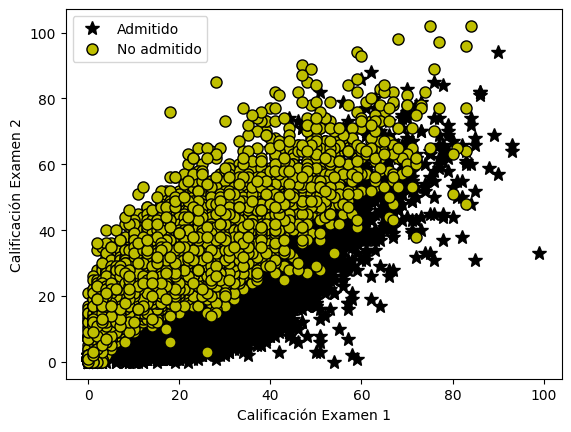

In [6]:
plotData(X, y)
# adiciona etiquetas para los ejes
pyplot.xlabel('Calificación Examen 1')
pyplot.ylabel('Calificación Examen 2')
pyplot.legend(['Admitido', 'No admitido'])
pass

<a id="section1"></a>
### 1.2 Implementacion

#### 1.2.1 Fución Sigmoidea

La hipotesis para la regresión logistica se define como:

$$ h_\theta(x) = g(\theta^T x)$$

donde la función $g$ is la función sigmoidea. La función sigmoidea se define como:

$$g(z) = \frac{1}{1+e^{-z}}$$.

Los resultados que debe generar la funcion sigmoidea para valores positivos amplios de `x`, deben ser cercanos a 1, mientras que para valores negativos grandes, la sigmoide debe generar valores cercanos 0. La evaluacion de `sigmoid(0)` debe dar un resultado exacto de 0.5. Esta funcion tambien debe poder trabajar con vectores y matrices.

In [7]:
def sigmoid(z):
    # Calcula la sigmoide de una entrada z
    # convierte la intrada a un arreglo numpy
    z = np.array(z)

    g = np.zeros(z.shape)

    g = 1 / (1 + np.exp(-z))

    return g

Se calcula el valor de la sigmoide aplicando la funcion sigmoid con `z=0`, se debe obtener un resultado de 0.5. RE recomienda experimentar con otros valores de `z`.

In [8]:
# Prueba la implementacion de la funcion sigmoid
z = [0, 0.5, 1]
g = sigmoid(z)

print('g(', z, ') = ', g)

g( [0, 0.5, 1] ) =  [0.5        0.62245933 0.73105858]


<a id="section2"></a>
#### 1.2.2 Función de Costo y Gradiente

Se implementa la funcion cost y gradient, para la regresión logistica. Antes de continuar es importante agregar el termino de intercepcion a X.

In [9]:
# Configurar la matriz adecuadamente, y agregar una columna de unos que corresponde al termino de intercepción.
m, n = X.shape
# Agraga el termino de intercepción a A
X = np.concatenate([np.ones((m, 1)), X], axis=1)

La funcion de costo en una regresión logistica es:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h_\theta\left( x^{(i)} \right) \right) \right]$$

y el gradiente del costo es un vector de la misma longitud como $\theta$ donde el elemento $j^{th}$ (para $j = 0, 1, \cdots , n$) se define como:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

Si bien este gradiente parece idéntico al gradiente de regresión lineal, la fórmula es diferente porque la regresión lineal y logística tienen diferentes definiciones de $h_\theta(x)$.
<a id="costFunction"></a>

In [10]:
def calcularCosto(theta, X, y):
    # Inicializar algunos valores utiles
    m = y.size  # numero de ejemplos de entrenamiento

    J = 0
    h = sigmoid(X.dot(theta.T))
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))

    return J

In [11]:
def descensoGradiente(theta, X, y, alpha, num_iters):
    m = len(y)  # Número de ejemplos de entrenamiento
    J_history = []

    for i in range(num_iters):
        # Calcula la predicción usando la hipótesis
        h = sigmoid(np.dot(X, theta))

        # Calcula el error entre la predicción y los valores reales
        error = h - y

        # Actualiza los parámetros theta
        theta -= (alpha / m) * np.dot(X.T, error)

        # Calcula el costo para la iteración actual y lo almacena
        J = (1 / (2 * m)) * np.sum(error ** 2)
        J_history.append(J)

    return theta, J_history

Primeros 10 valores de J_history: [0.6900527452963187, 0.6870186754564606, 0.6840432329951431, 0.6811247266966364, 0.6782615117123474, 0.6754519890192416, 0.6726946048078261, 0.669987849808007, 0.6673302585606485, 0.6647204086421763]


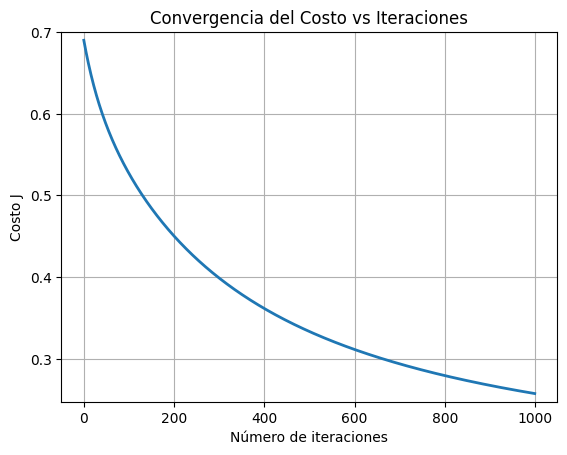

Theta calculado por el descenso por el gradiente: [ 0.64941592 -1.36234183  0.47560882 -0.1518427   0.02746979 -0.05096484
 -0.04955286  0.53639014 -0.03746838  0.72736668]


In [20]:
import numpy as np
import matplotlib.pyplot as pyplot
from sklearn.preprocessing import StandardScaler

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def costoRegresionLogistica(theta, X, y):
    m = len(y)
    h = sigmoid(np.dot(X, theta))
    return (-1/m) * (np.dot(y, np.log(h)) + np.dot((1-y), np.log(1-h)))

def descensoGradiente(theta, X, y, alpha, num_iters):
    m = len(y)
    J_history = []

    for i in range(num_iters):
        h = sigmoid(np.dot(X, theta))
        theta = theta - (alpha/m) * np.dot(X.T, (h - y))
        J_history.append(costoRegresionLogistica(theta, X, y))

    return theta, J_history

# Parámetros iniciales
alpha = 0.01  # Incrementar alpha
num_iters = 1000  # Incrementar el número de iteraciones

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Inicializar theta con ceros para 10 características
theta = np.zeros(10)

# Realizar el descenso por el gradiente
theta, J_history = descensoGradiente(theta, X_train_scaled, y_train, alpha, num_iters)

# Mostrar los primeros 10 valores de J_history para verificar
print("Primeros 10 valores de J_history:", J_history[:10])

# Verificar que J_history no esté vacío y que tenga valores válidos
if len(J_history) > 0 and np.all(np.isfinite(J_history)):
    # Graficar la convergencia del costo
    pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
    pyplot.xlabel('Número de iteraciones')
    pyplot.ylabel('Costo J')
    pyplot.title('Convergencia del Costo vs Iteraciones')
    pyplot.grid(True)

    # Ajustar la escala del eje Y si los valores son válidos
    min_y = min(J_history) - 0.01
    max_y = max(J_history) + 0.01
    if min_y < max_y:
        pyplot.ylim(min_y, max_y)

    pyplot.show()
else:
    print("Error: J_history está vacío o contiene valores no válidos.")

# Mostrar los resultados del descenso por el gradiente
print('Theta calculado por el descenso por el gradiente: {:s}'.format(str(theta)))

# Verificar la probabilidad de un evento (por ejemplo, un estudiante pasa o no)
X_array = [10, 2, 19, 22427, 30001, 10.0, 89, 3, 10791, 24827]

# Escalar las características del array de prueba
X_array_scaled = scaler.transform([X_array])

# Calcular la probabilidad
aprueba = sigmoid(np.dot(X_array_scaled, theta))



In [22]:
import numpy as np

# Supongamos que estas son las características relevantes para el estudiante.
# Puedes adaptar los valores para que coincidan con las características de tu dataset.
X_array = [1, 36, 39, 22427, 30001, 10.0, 89, 3, 10791, 24827]

# Escalar las características del array
X_array_scaled = scaler.transform([X_array])

# Calcular la predicción usando la función sigmoide
y_predicted = sigmoid(np.dot(X_array_scaled, theta))

# Mostrar el resultado
print('Un estudiante con las siguientes características:')
print(f'Características: {X_array}')
print(f'Predicción (probabilidad de aprobación): {y_predicted[0]:.2f}')

Un estudiante con las siguientes características:
Características: [1, 36, 39, 22427, 30001, 10.0, 89, 3, 10791, 24827]
Predicción (probabilidad de aprobación): 0.05


In [23]:
def costFunction(theta, X, y):
    # Inicializar algunos valores utiles
    m = y.size  # numero de ejemplos de entrenamiento

    J = 0
    grad = np.zeros(theta.shape)

    h = sigmoid(X.dot(theta.T))

    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))
    grad = (1 / m) * (h - y).dot(X)

    return J, grad

Se prueba la funcion `costFunction` utilizando dos casos de prueba para $\theta$.

In [24]:
# Inicializacion de parametros de ajuste
initial_theta = np.zeros(n+1)
print(initial_theta)
cost, grad = costFunction(initial_theta, X, y)

print('Costo en theta inicial (zeros): {:.3f}'.format(cost))
print('Costo esperado (aproximado): 0.693\n')
print(grad)
print('Gradiente en theta inicial (zeros):')
print('\t[{:.4f}, {:.4f}, {:.4f}]'.format(*grad))
print('Gradiente esperado (aproximado):\n\t[-0.1000, -12.0092, -11.2628]\n')



[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Costo en theta inicial (zeros): 0.693
Costo esperado (aproximado): 0.693

[-9.29264394e-05 -2.93965357e+00  2.86568412e+00 -5.18224733e+00
 -3.22821773e+03 -2.14375122e+03 -3.19168866e-01 -6.72779987e+00
 -7.34899454e-01 -1.63233126e+03 -6.91744097e+03]
Gradiente en theta inicial (zeros):
	[-0.0001, -2.9397, 2.8657]
Gradiente esperado (aproximado):
	[-0.1000, -12.0092, -11.2628]



In [26]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def costoRegresionLogistica(theta, X, y):
    m = len(y)
    h = sigmoid(np.dot(X, theta))
    costo = (-1/m) * (np.dot(y, np.log(h)) + np.dot((1-y), np.log(1-h)))
    gradiente = (1/m) * np.dot(X.T, (h - y))
    return costo, gradiente

# Valores de theta para probar
test_theta = np.array([-24, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

# Escalar X antes de calcular el costo y el gradiente
X_train_scaled = scaler.fit_transform(X_train)

# Calcular costo y gradiente con los valores de prueba
cost, grad = costoRegresionLogistica(test_theta, X_train_scaled, y_train)

# Mostrar resultados
print('Costo en theta prueba: {:.3f}'.format(cost))
print('Costo esperado (aproximado): ---')  # Como has adaptado, no hay un valor esperado exacto

print('Gradiente en theta prueba:')
print('\t[{:s}]'.format(', '.join(['{:.3f}'.format(g) for g in grad])))
print('Gradiente esperado (aproximado):\n\t---')  # Como has adaptado, no hay un valor esperado exacto

Costo en theta prueba: nan
Costo esperado (aproximado): ---
Gradiente en theta prueba:
	[-0.617, 0.106, -0.529, -0.408, -0.461, -0.413, -0.215, -0.562, -0.341, -0.499]
Gradiente esperado (aproximado):
	---


<ipython-input-26-023f6f29adc5>:9: RuntimeWarning: divide by zero encountered in log
  costo = (-1/m) * (np.dot(y, np.log(h)) + np.dot((1-y), np.log(1-h)))


#### 1.2.3 Parámetros de aprendizaje usando `scipy.optimize`

En el codigo anterior se encontró los parámetros óptimos de un modelo de regresión lineal al implementar el descenso de gradiente. Se implemento una función de costo y se calculó su gradiente, utilizando el algoritmo del descenso por el gradiente.

En lugar de realizar los pasos del descenso por el gradiente, se utilizará el [módulo `scipy.optimize`] (https://docs.scipy.org/doc/scipy/reference/optimize.html). SciPy es una biblioteca de computación numérica para `python`. Proporciona un módulo de optimización para la búsqueda y minimización de raíces. A partir de `scipy 1.0`, la función` scipy.optimize.minimize` es el método a utilizar para problemas de optimización (tanto restringidos como no restringidos).

For logistic regression, you want to optimize the cost function $J(\theta)$ with parameters $\theta$.
Concretely, you are going to use `optimize.minimize` to find the best parameters $\theta$ for the logistic regression cost function, given a fixed dataset (of X and y values). You will pass to `optimize.minimize` the following inputs:

Para la regresión logística, se desea optimizar la función de costo $J(\theta)$ con los parámetros $\theta$.
Concretamente, se va a utilizar `optimize.minimize` para encontrar los mejores parámetros $\theta$ para la función de costo de regresión logística, dado un dataset fijo (de valores X e y). Se pasara a `optimize.minimize` las siguientes entradas:

- `costFunction`: Una función de costo que, cuando se le da el dataset de entrenamiento y un $\theta$ particular, calcula el costo de regresión logística y el gradiente con respecto a $\theta$ para el dataset(X, y). Es importante tener en cuenta que solo se pasa el nombre de la función sin el paréntesis. Esto indica que solo proporcionamos una referencia a esta función y no evaluamos el resultado de esta función.
- `initial_theta`: Los valores iniciales de los parametros que se tratan de optimizar.
- `(X, y)`: Estos son argumentos adicionales a la funcion de costo.
- `jac`: Indicación si la función de costo devuelve el jacobiano (gradiente) junto con el valor de costo. (True)
- `method`: Método / algoritmo de optimización a utilizar
- `options`: Opciones adicionales que pueden ser específicas del método de optimización específico. Solo se indica al algoritmo el número máximo de iteraciones antes de que termine.

Si se ha completado la `costFunction` correctamente,`optimize.minimize` convergerá en los parámetros de optimización correctos y devolverá los valores finales del costo y $\theta$ en un objeto de clase.

Al usar `optimize.minimize`, no se tuvo que escribir ningún bucle ni establecer una tasa de aprendizaje como se hizo para el descenso de gradientes. Todo esto se hace mediante `optimize.minimize`: solo se necesita proporcionar una función que calcule el costo y el gradiente.

A continuación, se tiene el código para llamar a `optimize.minimize` con los argumentos correctos.

In [27]:
import numpy as np
from scipy import optimize

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def costoRegresionLogistica(theta, X, y):
    m = len(y)
    h = sigmoid(np.dot(X, theta))
    costo = (-1/m) * (np.dot(y, np.log(h)) + np.dot((1-y), np.log(1-h)))
    gradiente = (1/m) * np.dot(X.T, (h - y))
    return costo, gradiente

# Escalar X antes de la optimización
X_train_scaled = scaler.fit_transform(X_train)

# Inicializar theta con ceros para 10 características
initial_theta = np.zeros(X_train_scaled.shape[1])

# Establecer las opciones para optimize.minimize
options = {'maxiter': 1000}

# Usar scipy.optimize.minimize para optimizar el theta
res = optimize.minimize(costoRegresionLogistica,
                        initial_theta,
                        args=(X_train_scaled, y_train),
                        jac=True,
                        method='TNC',
                        options=options)

# Extraer el costo y theta optimizado del resultado
cost = res.fun
theta = res.x

# Imprimir resultados
print('Costo con un valor de theta encontrado por optimize.minimize: {:.3f}'.format(cost))
print('Costo esperado (aproximado): ---')  # Como has adaptado, no hay un valor esperado exacto

print('theta:')
print('\t[{:s}]'.format(', '.join(['{:.3f}'.format(t) for t in theta])))
print('Theta esperado (aproximado): ---')  # Como has adaptado, no hay un valor esperado exacto

Costo con un valor de theta encontrado por optimize.minimize: 0.146
Costo esperado (aproximado): ---
theta:
	[3.604, -4.506, 0.363, -0.144, 0.479, 0.154, -1.192, -0.096, -0.091, 1.678]
Theta esperado (aproximado): ---


<ipython-input-27-ba7cdd3125c5>:24: OptimizeWarning: Unknown solver options: maxiter
  res = optimize.minimize(costoRegresionLogistica,


Una vez que se completa `optimize.minimize`, se usa el valor final de $\theta$ para visualizar el límite de decisión en los datos de entrenamiento.

Para hacerlo, se implementa la función `plotDecisionBoundary` para trazar el límite de decisión sobre los datos de entrenamiento.

In [30]:
def plotDecisionBoundary(plotData, theta, X, y):
    """
    Grafica los puntos X y Y en una nueva figura con un limite de desicion definido por theta.
    the data points X and y into a new figure with the decision boundary defined by theta.
    Grafica los puntos con * para los ejemplos positivos y con o para los ejemplos negativos.

    Parametros:
    ----------
    plotData : func
        A function reference for plotting the X, y data.

    theta : array_like
        Parametros para la regresion logistica. Un vecto de la forma (n+1, ).

    X : array_like
        Data set de entrada. Se supone que X es una de las siguientes:
            1) Matriz Mx3, donde la primera columna es una columna de unos para intercepción.
            2) Matriz MxN, N> 3, donde la primera columna son todos unos.

    y : array_like
        Vector de datos de etiquetas de la forma (m, ).
    """
    # hacer que theta sera un arreglo numpy
    theta = np.array(theta)

    # Graficar los datos (recordar que la primera columna en X es la intercepción)
    plotData(X[:, 1:3], y)

    if X.shape[1] <= 3:
        # Solo se requieren 2 puntos para definir una linea, para lo cual se eligen dos puntos finales
        plot_x = np.array([np.min(X[:, 1]) - 2, np.max(X[:, 1]) + 2])

        # Calcular la línea límite de decisión
        plot_y = (-1. / theta[2]) * (theta[1] * plot_x + theta[0])

        print(plot_x)
        print(plot_y)
        # Graficar y ajustar los ejes para una mejor visualización
        pyplot.plot(plot_x, plot_y)

        # Leyenda, especifica para el ejercicio
        pyplot.legend(['Admitido', 'No admitido', 'Limite de decisión'])
        pyplot.xlim([30, 100])
        pyplot.ylim([30, 100])
    else:
        # Rango de la grilla
        u = np.linspace(-1, 1.5, 50)
        v = np.linspace(-1, 1.5, 50)

        z = np.zeros((u.size, v.size))
        # Evalua z = theta*x sobre la grilla
        for i, ui in enumerate(u):
            for j, vj in enumerate(v):
                z[i, j] = np.dot(mapFeature(ui, vj), theta)

        z = z.T  # importante transponer z antes de llamar al contorno
        # print(z)

        # Plot z = 0
        pyplot.contour(u, v, z, levels=[0], linewidths=2, colors='g')
        pyplot.contourf(u, v, z, levels=[np.min(z), 0, np.max(z)], cmap='Greens', alpha=0.4)


NameError: name 'mapFeature' is not defined

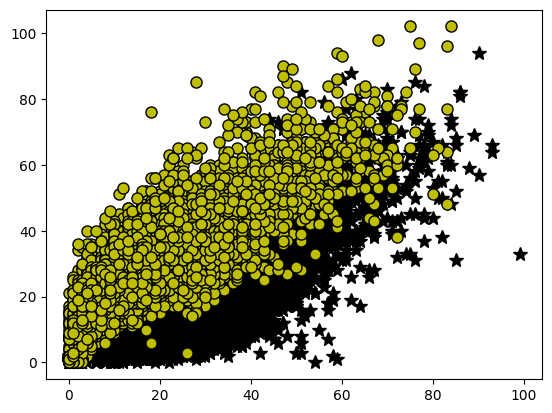

In [31]:
# Graficar limites
plotDecisionBoundary(plotData, theta, X, y)

<a id="section4"></a>
#### 1.2.4 Evaluación de la regresión logistica

Después de aprender los parámetros, se puede usar el modelo para predecir si un estudiante en particular será admitido. Para un estudiante con una puntuación en el Examen 1 de 45 y una puntuación en el Examen 2 de 85, debe esperar ver una probabilidad de admisión de 0,776. Otra forma de evaluar la calidad de los parámetros que hemos encontrado es ver qué tan bien predice el modelo aprendido en nuestro conjunto de entrenamiento.

In [34]:
def predict(theta, X):
    """
    Predecir si la etiqueta es 0 o 1 mediante regresión logística aprendida.
    Calcula las predicciones para X usando un umbral en 0.5 (es decir, si sigmoide (theta.T * x) >= 0.5, predice 1)

    Parametros
    ----------
    theta : array_like
        Parametros para regresion logistica. Un vector de la forma (n+1, ).

    X : array_like
        Datos utilizados para el calculo de las predicciones.
        La fila es el numero de los puntos para calcular las predicciones,
        y las columnas con el numero de caracteristicas.

    Devuelve
    -------
    p : array_like
        Predicciones y 0 o 1 para cada fila en X.
    """
    m = X.shape[0]  # Número de ejemplos de entrenamiento
    p = np.zeros(m)

    # Calcular la probabilidad y redondear para obtener 0 o 1
    p = np.round(sigmoid(X.dot(theta)))
    return p


Una vez entrenado el modelo se procede a realizar la prediccion y evaluación de los resultados de predecir cual es el valor que vota el modelo para todos los datos utilizados en el entrenamiento.

In [41]:
import numpy as np

# Definir la función sigmoide
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Ejemplo de características para un nuevo estudiante
student_features = [45, 85, 0, 0, 0, 0, 0, 0, 0, 0]  # Características reales sin el término de sesgo

# Escalar las características del estudiante
student_features_scaled = scaler.transform([student_features])

# Añadir el término de sesgo nuevamente al inicio del array
student_features_scaled = np.insert(student_features_scaled, 0, 1, axis=1)

# Asegurarse de que theta tiene 11 elementos (incluyendo el término de sesgo)
if theta.shape[0] == 10:
    theta = np.insert(theta, 0, 1)

# Verificar las dimensiones antes de la operación de producto punto
print("Dimensiones de student_features_scaled:", student_features_scaled.shape)
print("Dimensiones de theta:", theta.shape)

# Calcular la probabilidad usando el producto punto
try:
    prob = sigmoid(np.dot(student_features_scaled, theta))
    print('Para un estudiante con las características dadas, se predice una probabilidad de admisión de: {:.3f}'.format(prob[0]))
except Exception as e:
    print(f"Error al calcular la probabilidad: {e}")

Dimensiones de student_features_scaled: (1, 11)
Dimensiones de theta: (11,)
Para un estudiante con las características dadas, se predice una probabilidad de admisión de: 0.000
